# Project 4: Regression on Time Series

## carlos.e.hernandez@<>.com
### Slack: carlosh

# Introduction	
In this project, you will predict future sales based on historical data. There is a lot of signal in the historical data about future sales - average sales across various periods, trends, seasonality... However, this information needs to be extracted from data by creating new features. You will really get your hands dirty with data on this one!

It is extremely important to use a correct validation schema when working with time series data. One cannot just use a random split as that would mean that a ML model uses information from the future (e.g. sales at a different store but from the same time period). Training/validation split needs to be based on time with validation set being the more fresh dataset.  

## Time required
5 weeks

# Resources - DELETE ME!

* https://www.kaggle.com/headsortails/shopping-for-insights-favorita-eda
* https://medium.com/keita-starts-data-science/time-series-split-with-scikit-learn-74f5be38489e
* https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html




# Environment variables

Make sure to configure these variables to the apropriate locations and to set them prior to executing any import Python statement.

In [1]:
# Set this variable to wherever you want to download these additional files
#%env DATA_LOCATION=/content/drive/MyDrive/Colab Notebooks/Oracle/Assignment4
%env DATA_LOCATION=/workspace/jupyter_workspace/Oracle/Assignment4
!echo $DATA_LOCATION

env: DATA_LOCATION=/workspace/jupyter_workspace/Oracle/Assignment4
/workspace/jupyter_workspace/Oracle/Assignment4


# Extract data from a compressed archive

This step is optional and should act as a way to ensure the data is uncompressed
and ready to be read by pandas.

In [ ]:
#!unzip "$DATA_LOCATION/favorita-grocery-sales-forecasting.zip" -d "$DATA_LOCATION"

# Extract files using bash-based 7za OR a Python module called py7zr
#!7za e "$DATA_LOCATION/train.csv.7z" -o"$DATA_LOCATION"
#!7za e "$DATA_LOCATION/test.csv.7z" -o"$DATA_LOCATION"
#!python -m py7zr x "$DATA_LOCATION/train.csv.7z" "$DATA_LOCATION"
#!python -m py7zr x "$DATA_LOCATION/test.csv.7z" "$DATA_LOCATION"

# Pandas doesn't support 7z compression and we don't want to have the data using
#  a lot of physical space, instead we could extract on-the-fly and save GB of
#  storage. Let's compress these CSV files into ZIP archives

#!zip "$DATA_LOCATION/test.csv.zip" "$DATA_LOCATION/test.csv"
#!zip "$DATA_LOCATION/train.csv.zip" "$DATA_LOCATION/train.csv"

# Clean the redundant files

#!rm "$DATA_LOCATION/train.csv"
#!rm "$DATA_LOCATION/test.csv"
#!rm "$DATA_LOCATION/test.csv.7z"
#!rm "$DATA_LOCATION/train.csv.7z"

!ls -lah "$DATA_LOCATION"

total 898M
drwx------ 2 1153 1153 4.0K Feb 11 00:00 .
drwx------ 3 1153 1153 4.0K Feb 10 23:30 ..
-rwx------ 1 1153 1153 1.9K Dec 11  2019 holidays_events.csv.7z
-rwx------ 1 1153 1153  14K Dec 11  2019 items.csv.7z
-rwx------ 1 1153 1153 3.7K Dec 11  2019 oil.csv.7z
-rwx------ 1 1153 1153 651K Dec 11  2019 sample_submission.csv.7z
-rwx------ 1 1153 1153  648 Dec 11  2019 stores.csv.7z
-rw-r--r-- 1 root root  20M Feb 10 23:57 test.csv.zip
-rw-r--r-- 1 root root 878M Feb 10 23:59 train.csv.zip
-rwx------ 1 1153 1153 215K Dec 11  2019 transactions.csv.7z


# Imports and tools



In [ ]:
#!pip install matplotlib scikit-learn numpy pandas 

In [2]:
%matplotlib inline

import os
import random
import itertools
import re

from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

# Connect to Google Drive if hosting the files there
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
def print_marquee(msg: str):
    """
    Prints a centered message with a marquee of * 
    """
    marquee_width = len(msg) + 4
    print("\n")
    print("*" * marquee_width)
    print(f"* {msg} *")
    print("*" * marquee_width)

# Data TBD

https://www.kaggle.com/c/favorita-grocery-sales-forecasting/overview

## Context

In this competition, you will be predicting the unit sales for thousands of items sold at different Favorita stores located in Ecuador. The training data includes dates, store and item information, whether that item was being promoted, as well as the unit sales. Additional files include supplementary information that may be useful in building your models.

## Training Data
Training data, which includes the target `unit_sales` by `date`, `store_nbr`, and `item_nbr` and a unique `id` to label rows.

The target `unit_sales` can be integer (e.g., a bag of chips) or float (e.g., 1.5 kg of cheese).

Negative values of `unit_sales` represent returns of that particular item.

The `onpromotion` column tells whether that `item_nbr` was on promotion for a specified date and store_nbr.

Approximately 16% of the `onpromotion` values in this file are `NaN`.

NOTE: The training data does not include rows for items that had zero unit_sales for a store/date combination. There is no information as to whether or not the item was in stock for the store on the date, and teams will need to decide the best way to handle that situation. Also, there are a small number of items seen in the training data that aren't seen in the test data.

## Test Data
Test data, with the `date`, `store_nbr`, `item_nbr` combinations that are to be predicted, along with the onpromotion information.

NOTE: The test data has a small number of items that are not contained in the training data. Part of the exercise will be to predict a new item sales based on similar products.

## Columns

1. id           int64 
1. date         object 
1. store_nbr    int64  
1. item_nbr     int64  
1. onpromotion  object 

### Dependant variable
1. unit_sales   float64


In [ ]:
data_root_location = os.environ["DATA_LOCATION"]
#chunksize = 10 ** 6

train_data = pd.read_csv(f"{data_root_location}/train.csv.zip",
                         #chunksize=chunksize,
                         compression='zip',
                         parse_dates=["date"]
                         )

test_data = pd.read_csv(f"{data_root_location}/test.csv.zip",
                         #chunksize=chunksize,
                         compression='zip',
                         parse_dates=["date"]
                         )

#data_descriptions = []

#for chunk in data:
#    data_descriptions.append(chunk.describe().T)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## EDA

Let's first figure out the main information of the train and test datasets.

In [ ]:
print_marquee("Train Data summary:")
display(train_data.info(null_counts=True))

print("\n\nData Description:")
display(train_data.describe(include="all", datetime_is_numeric=True))


print_marquee("Test Data summary:")
display(test_data.info(null_counts=True))

print("\n\nData Description:")
display(test_data.describe(include="all", datetime_is_numeric=True))



***********************
* Train Data summary: *
***********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Non-Null Count      Dtype         
---  ------       --------------      -----         
 0   id           125497040 non-null  int64         
 1   date         125497040 non-null  datetime64[ns]
 2   store_nbr    125497040 non-null  int64         
 3   item_nbr     125497040 non-null  int64         
 4   unit_sales   125497040 non-null  float64       
 5   onpromotion  103839389 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 5.6+ GB


None



Data Description:


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
count,1.254970e+08,125497040,1.254970e+08,1.254970e+08,1.254970e+08,103839389
unique,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,96028767
mean,6.274852e+07,2015-09-15 16:43:18.789246720,2.746458e+01,9.727692e+05,8.554865e+00,NaN
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,9.699500e+04,-1.537200e+04,NaN
25%,3.137426e+07,2014-09-20 00:00:00,1.200000e+01,5.223830e+05,2.000000e+00,NaN
50%,6.274852e+07,2015-11-21 00:00:00,2.800000e+01,9.595000e+05,4.000000e+00,NaN
75%,9.412278e+07,2016-10-17 00:00:00,4.300000e+01,1.354380e+06,9.000000e+00,NaN
max,1.254970e+08,2017-08-15 00:00:00,5.400000e+01,2.127114e+06,8.944000e+04,NaN




**********************
* Test Data summary: *
**********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370464 entries, 0 to 3370463
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           3370464 non-null  int64         
 1   date         3370464 non-null  datetime64[ns]
 2   store_nbr    3370464 non-null  int64         
 3   item_nbr     3370464 non-null  int64         
 4   onpromotion  3370464 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(3)
memory usage: 106.1 MB


None



Data Description:


,id,date,store_nbr,item_nbr,onpromotion
count,3.370464e+06,3370464,3.370464e+06,3.370464e+06,3370464
unique,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,3171867
mean,1.271823e+08,2017-08-23 12:00:00.000003072,2.750000e+01,1.244798e+06,NaN
min,1.254970e+08,2017-08-16 00:00:00,1.000000e+00,9.699500e+04,NaN
25%,1.263397e+08,2017-08-19 18:00:00,1.400000e+01,8.053210e+05,NaN
50%,1.271823e+08,2017-08-23 12:00:00,2.750000e+01,1.294665e+06,NaN
75%,1.280249e+08,2017-08-27 06:00:00,4.100000e+01,1.730015e+06,NaN
max,1.288675e+08,2017-08-31 00:00:00,5.400000e+01,2.134244e+06,NaN


## Histograms

### Train data



**************
* Train data *
**************


<AxesSubplot:title={'center':'Unit sales by month'}, xlabel='date,date'>

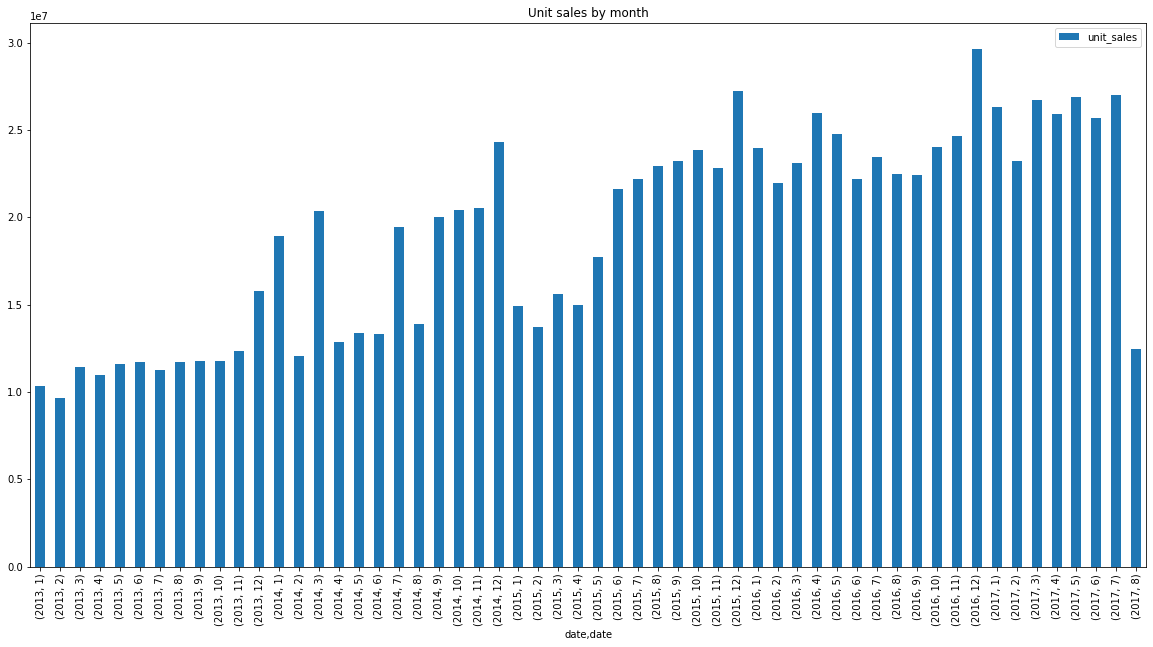

In [ ]:
print_marquee("Train data")
train_data[["date", "unit_sales"]].groupby([train_data["date"].dt.year,
                                            train_data["date"].dt.month]).sum().plot(kind="bar",
                                                                                     figsize=(20,10),
                                                                                     title="Unit sales by month")



**************
* Train data *
**************


<AxesSubplot:title={'center':'Record count by month (Train data)'}, xlabel='date,date'>

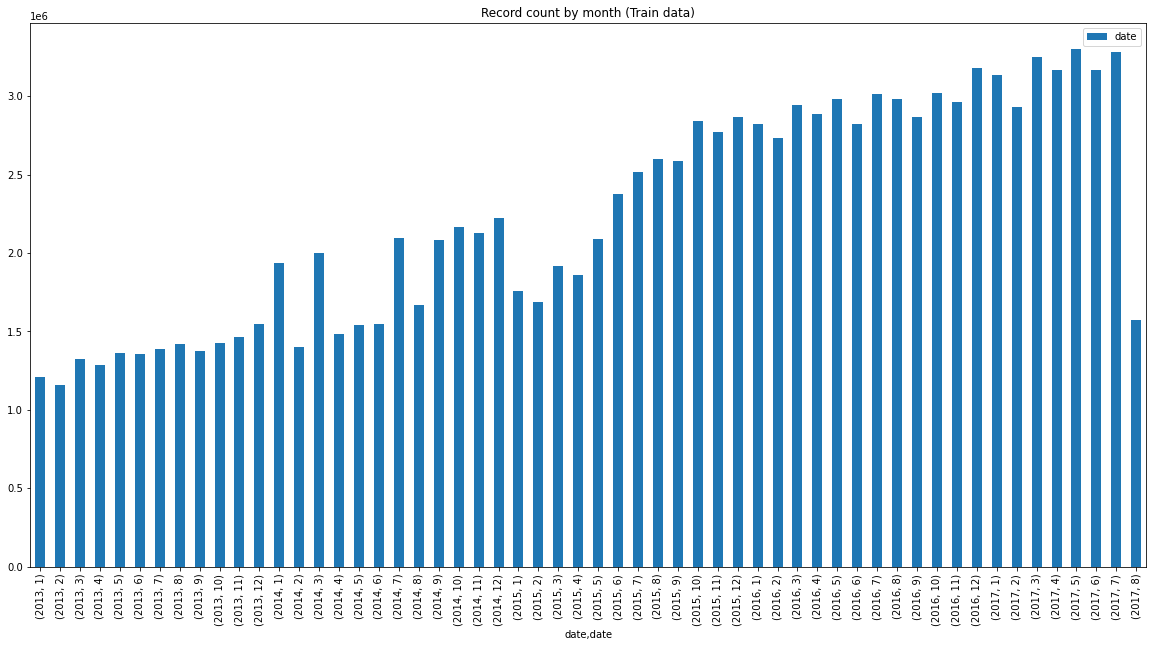

In [ ]:
print_marquee("Train data")
train_data[["date"]].groupby([train_data["date"].dt.year,
                              train_data["date"].dt.month]).count().plot(kind="bar",
                                                                         figsize=(20,10),
                                                                         title="Record count by month (Train data)")

### Test data



*************
* Test data *
*************


<AxesSubplot:title={'center':'Record counts by day (Test data)'}, xlabel='date,date,date'>

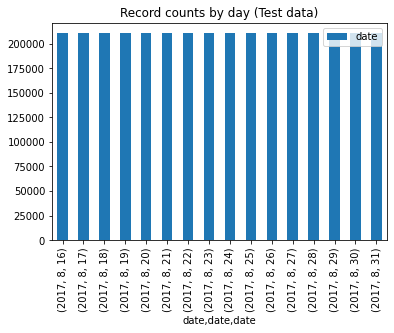

In [ ]:
print_marquee("Test data")
test_data[["date"]].groupby([test_data["date"].dt.year,
                             test_data["date"].dt.month,
                             test_data["date"].dt.day]).count().plot(kind="bar",
                                                                     title="Record counts by day (Test data)")

We are able to see that all the columns in the training data, except for `onpromotion` do not contain null values. Training data corresponds to records
compiled between January 1st 2013 and August 15th 2017.

The test data doesn't contain any null value and the records were compiled between August 16th 2017 and August 31st 2017 which allows us to verify that, should we use all records from the training dataset, they do not contain data from "the future" which are all of the records contained in the test dataset.

We can also see that there are spikes of sales around December of each year, which is most likely due to the Holidays. Another interesting thing to note is that the organization has been capturing more records as the year go by.

However, given that our test data has sales data to predict for 2 weeks we might want to only use the relevant data for the 2 years prior, both to ease the training and to avoid introducing data that may not be as relevant for the period for which we want to predict.

## Filtering of training data

From the analysis above we can see that we have data from almost 4 years before what the test data is looking for. While this ammount of data may provide more insight, it may also be true that sales data from 2013 may not be as relevant to 2017 sales.

We could instead use only data from 2015 onwards, this will allow us to get more relevant data and reduce the sheer size of the dataset that will be used during training.

In [ ]:
train_data = train_data[train_data["date"] >= "2015-06"]

train_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77599003 entries, 47898037 to 125497039
Data columns (total 6 columns):
 #   Column       Non-Null Count     Dtype         
---  ------       --------------     -----         
 0   id           77599003 non-null  int64         
 1   date         77599003 non-null  datetime64[ns]
 2   store_nbr    77599003 non-null  int64         
 3   item_nbr     77599003 non-null  int64         
 4   unit_sales   77599003 non-null  float64       
 5   onpromotion  77599003 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 4.0+ GB


## Feature engineering

Before we can continue with the EDA we should clean up the data a little bit, this should allow us to have a better insight into trends and for models to be able to process the data.

We shall:

1. Any `NaN` value in `onpromotion` will be set to `False`. We don't have information on whether the article was on promotion or not, but the most common case is that it isn't.
1. Not use the `id` column for training, only for identifying the original record.
1. Break up the `date` column into the following and remove it:
    1. `season`. Which will represent with the following numeric values whether the sale happened:
        * 0 = Spring. [March - May]
        * 1 = Summer. [June - August]
        * 2 = Fall. [September - November]
        * 3 = Winter. [December - February]
    1. `time_of_day`. Which will have the following values:
        * 0 = Early Morning. [12:00 am - 5:59 am]
        * 1 = Morning [6:00 am - 11:59 am]
        * 2 = Afternoon [12:00 pm - 5:59 pm]
        * 3 = Evening [6:00 pm - 11:59 pm]
    1. `year`
    1. `day_of_week`
        * 0 = Monday
        * 1 = Tuesday
        * 2 = Wednesday
        * 3 = Thursday
        * 4 = Friday
        * 5 = Saturday
        * 6 = Sunday


In [ ]:
%time

def determine_season(row: pd.Series) -> int:
    """
    Refer to https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html
    """
    month = row['date'].month

    if 3 <= month <= 5:
        return 0
    elif 6 <= month <= 8:
        return 1
    elif 9 <= month <= 11:
        return 2
    else:
        return 3

def determine_time_of_day(row: pd.Series) -> int:
    hour = row['date'].hour
    return hour


def feature_engineer_df(df: pd.DataFrame) -> pd.DataFrame:

    # Fill NA values for onpromotion
    df["onpromotion"].fillna(False, inplace=True)

    df['season'] = df.apply(determine_season, axis=1)
    df["year"] = df.apply(lambda row: row["date"].year, axis=1)
    df["day_of_week"] = df.apply(lambda row: row["date"].dayofweek, axis=1)
    #df['time_of_day'] = df.apply(determine_time_of_day, axis=1)


    return df

train_data = feature_engineer_df(train_data)

display(train_data.iloc[2000000:2000050])

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,season,year,day_of_week
49898037,49898037,2015-06-26,16,1179580,2.000,False,1,2015,4
49898038,49898038,2015-06-26,16,1209719,3.000,False,1,2015,4
49898039,49898039,2015-06-26,16,1209720,6.000,False,1,2015,4
49898040,49898040,2015-06-26,16,1209721,4.000,False,1,2015,4
49898041,49898041,2015-06-26,16,1225771,4.000,False,1,2015,4
49898042,49898042,2015-06-26,16,1228320,2.000,False,1,2015,4
49898043,49898043,2015-06-26,16,1229025,7.000,False,1,2015,4
49898044,49898044,2015-06-26,16,1229028,1.000,False,1,2015,4
49898045,49898045,2015-06-26,16,1229636,1.000,False,1,2015,4
49898046,49898046,2015-06-26,16,1229642,2.000,False,1,2015,4


<AxesSubplot:title={'center':'Unit sales by season'}, xlabel='Season', ylabel='Unit sales'>

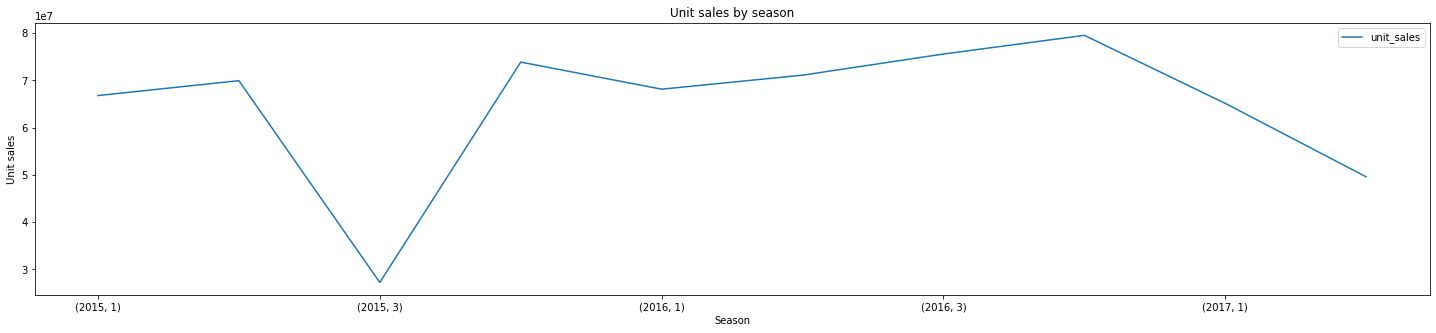

In [ ]:
train_data[["unit_sales"]].groupby([train_data["year"],
                                    train_data["season"]]).sum().plot(kind="line",
                                                                      figsize=(25,5),
                                                                      title="Unit sales by season",
                                                                      xlabel="Season",
                                                                      ylabel="Unit sales")

By seeing the volume of unit sales by season, we can see that there's usually a spie of sales just before the Holidays, although the Winter season in 2015 (Dec-Feb) had a significant drop in unit sales.

We can also see that there's a dip around summer 2017, but that's because there's not sufficient data for summer 2017.

## Correlation matrix

Let's compute the Pearson correlation coefficient and try to see if there's any feature that may be correlated to the dependant variable.

In [ ]:
display(train_data.drop(["id","date"], axis=1).corr(method="pearson"))

,store_nbr,item_nbr,unit_sales,onpromotion,season,year,day_of_week
store_nbr,1.000000,0.009253,0.039531,0.007083,-0.003376,0.011650,0.004884
item_nbr,0.009253,1.000000,0.020146,0.027273,-0.009984,0.103496,0.002725
unit_sales,0.039531,0.020146,1.000000,0.061015,0.004693,-0.009150,0.026665
onpromotion,0.007083,0.027273,0.061015,1.000000,-0.011152,0.087235,-0.011544
season,-0.003376,-0.009984,0.004693,-0.011152,1.000000,-0.222689,-0.004356
year,0.011650,0.103496,-0.009150,0.087235,-0.222689,1.000000,0.002935
day_of_week,0.004884,0.002725,0.026665,-0.011544,-0.004356,0.002935,1.000000


These correlations are not very strong, but we can see that the fact that a product is onpromotion is positively correlated to the unit sales.

## Train/Val Split

Given that we are dealing with time series a simple randomized train/val split will not work. We need to remember that the records in time-series analysis are not independent.

Instead, what we can do is use SKLearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) cross-validation. To cite the documentation:

> Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate.
> 
> This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.
>
> Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

What this means is that essentially, the splitter will create a small "sliding window" over the data (analogously, this is the k-fold in k-fold cross validation) making sure that the training set happens before the validation set. This will allow us to measure the ability of the regressor to correctly predict a value, that the model is sound without worrying about the having future data poison the training of the model.

Given that we already have a test dataset, we will take the train dataset and do the TimeSeriesSplit on it for the train/val split.

Before we can use the splitter, we need to make sure that the data is sorted by the date column appropriately. We'll also define the `n_splits` that make more sense for our data size, a bigger split (or "sliding windows") we use, the longer our training will take.




In [ ]:
%%time
# Order train data to prepare it for the split

train_data = train_data.sort_values(by='date', ascending=True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs


We'll now save this data that has been sorted and filtered so that in subsequent runs of the notebook we can quickly load it. If we've saved the data before, we should uncomment the cell after the following one and we can continue with the rest of the cells

In [ ]:
%%time
# Save the sorted and filtered data to disk

#train_data.to_csv(f"{data_root_location}/sorted_filtered_train_data.csv.zip",
#                  index=True,
#                  compression={
#                      "method": "zip",
#                      "archive_name": "sorted_filtered_train_data.csv"
#                      }
#                  )

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.7 µs


In [5]:
%%time
data_root_location = os.environ["DATA_LOCATION"]
train_data = pd.read_csv(f"{data_root_location}/sorted_filtered_train_data.csv.zip",
                         compression='zip',
                         parse_dates=["date"]
                         )

CPU times: user 1min 1s, sys: 6.97 s, total: 1min 8s
Wall time: 1min 8s


We are now ready to perform the Train/Val split on our ordered data

# Models TBD

For our models we'll use:
1. LinearRegression
1. NeuralNetwork

We could use a DecisionTree or an ensemble model like a RandomForest, however, while these are good and efficient ways of training a regression, it is known that DecisionTrees have problem generalizing to never-before-seen data such as that found in TimeSeries datasets.

We'll train a LinearRegression model with our TimeSeriesSplitter and we'll measure their performance for each split.


In [6]:
X_cols = ["store_nbr", "item_nbr", "onpromotion", "season", "year", "day_of_week"]
y_cols = ["unit_sales"]

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

for train_idx, val_idx in tscv.split(train_data):
    X = train_data.iloc[train_idx][X_cols]
    y = train_data.iloc[val_idx][y_cols]

    
